In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from IPython.display import clear_output as cls

# Data 
from tqdm import tqdm 
from glob import glob
import tensorflow.data as tfd

# Data Visualization
import plotly.express as px
import matplotlib.pyplot as plt

# Model
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras import applications as tka

In [3]:
!pip install keras_tuner
import keras_tuner as kt
cls()

In [4]:
# The batch size
BATCH_SIZE = 64

# Image dims 
IMAGE_SIZE = (120,120)                                    # Even this will work

# Buffer size
BUFFER = 1000

# Autotuning
AUTOTUNE = tfd.AUTOTUNE

In [5]:
# Setting the Random Seeds
np.random.seed(1024)
tf.random.set_seed(1024)

In [12]:
# Specify the root paths
train_path = "data2/training_data"
test_path  = "data2/testing_data"

In [13]:
# Get the class Names
class_names = sorted(os.listdir(train_path))

# Total number of classes
n_classes = len(class_names)

# Show
print(f"Total Number of Classes : {n_classes}")
print(f"Class Names : \n{class_names}")

Total Number of Classes : 36
Class Names : 
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [30]:
print(f"Training Images : {sum([len(os.listdir(os.path.join(train_path + '/' + name))) for name in class_names])}")
print(f"Testing  Images : {sum([len(os.listdir(os.path.join(test_path + '/' + name))) for name in class_names])}")

Training Images : 20628
Testing  Images : 3242


In [31]:
def load_image(image_path:str):

    '''
    This is a pwerful function designed to facilitate the loading of images from a specified image path, while simultaneously 
    carrying out critical preprocessing steps. Specifically, this function implements two key preprocessing techniques : resizing and normalization.
    
    By leveraging resizing, this function standardizes the dimensions of the images, ensuring that they are of a consistent size and format.
    This preprocessing step is essential to ensure that our analysis can be carried out accurately and efficiently, as it eliminates the risk
    of errors or inconsistencies that can arise from variations in image dimensions.
    
    In addition to resizing, this function also incorporates normalization as a critical preprocessing step. By standardizing the images,
    this technique helps to eliminate any variations that can affect the accuracy of our analysis, ensuring that our conclusions are robust and reliable.

    Argument : 
        image_path : The path to the image file.
    
    Return : 
        image : The loaded and prerocessed image.
    '''
    
    # Load image file
    image_loaded = tf.io.read_file(image_path)

    try:
        # Decode the png image
        image_decoded = tf.image.decode_png(contents=image_loaded, channels=3)
        
        # Convert the dtype
        image_cnvt = tf.image.convert_image_dtype(image=image_decoded, dtype=tf.float32)

        # Resize the image
        image_resize = tf.image.resize(images=image_cnvt, size=IMAGE_SIZE)

        # Normalize image
        image_norm = tf.clip_by_value(image_resize, clip_value_min=0.0, clip_value_max=1.0)

        # Just for security
        image = tf.cast(x=image_norm, dtype=tf.float32)

        # return
        return image
    except:
        pass


In [32]:
def load_data(root_path, class_names, trim=None, shuffle=False, split=None):

    '''
    This function is designed to simplify the process of collecting file paths from the root path based on class names, while simultaneously 
    loading the associated images and labels. By leveraging this function, we can streamline our data collection process, ensuring that we can
    rapidly access the files we need for our analysis.
    
    This functionality is particularly useful when working with large datasets, as it enables us to avoid the tedious manual effort of collecting
    file paths and loading images and labels separately. Once the images and labels have been collected, this function takes the additional step of
    converting them into a TensorFlow dataset, further streamlining the analysis process. 
    
    By transforming the data into this format, we can leverage TensorFlow's powerful functionality and algorithms, enabling us to quickly and 
    accurately analyze the data and extract valuable insights.

    Overall, this function is a powerful tool that streamlines the data collection and preprocessing process, enabling us to extract valuable
    insights from large and complex datasets.
    
    Arguments : 
        root_path   : The main directory from which the data should be collected.
        class_names : These are the class names or the sub directory names where the image files are present.
    
    Return : 
        data_set : The Tensorflow dataset of the images and labels.
    '''

    # Collect all file paths
    if trim is not None:
        details = [(path, name) for name in class_names for path in glob(pathname=f"{root_path}/{name}/*.png")[:trim]]
        
    else:
        details = [(path, name) for name in class_names for path in glob(pathname=f"{root_path}/{name}/*.png")]


    # Create space for images and labels
    images = np.empty(shape=(len(details), *IMAGE_SIZE, 3), dtype='float32')
    labels = np.empty(shape=(len(details), 1), dtype='int64')


    # Iterate over all file paths
    for index, (path, name) in tqdm(enumerate(details), desc="Loading"):

        # Load the image
        image = load_image(image_path=path)

        # get the label
        label = class_names.index(name)

        # Store this image and label
        images[index] = image
        labels[index] = label
    
    # Convert the data into tensorflow data
    data_set = tfd.Dataset.from_tensor_slices((
        images, labels
    ))

    # Shuffle if needed
    if shuffle:
        data_set = data_set.shuffle(BUFFER)
    
    # Split the data if needed
    if split is not None:
        
        # get the data sizes
        test_size = int(split * len(images))
        train_size = int(len(images) - test_size)
        
        # Split the data
        train_set = data_set.take(train_size)
        test_set  = data_set.skip(train_size).take(test_size)
        
        # Batchify the data
        train_set = train_set.batch(BATCH_SIZE).prefetch(AUTOTUNE)
        test_set = test_set.batch(BATCH_SIZE).prefetch(AUTOTUNE)
        
        # Return data
        return train_set, test_set
    
    else:
        # The whole data
        data_set = data_set.batch(BATCH_SIZE).prefetch(AUTOTUNE)
        
        # Return complete data
        return data_set

In [33]:
# Load Training data
train_ds = load_data(root_path=train_path, class_names=class_names, trim=300, shuffle=True)

# Load Validation data
test_ds, valid_ds = load_data(root_path=test_path, class_names=class_names, shuffle=True, split=0.2)
cls()

In [34]:
print(f"Training Data Size   : {tf.data.experimental.cardinality(train_ds).numpy() * BATCH_SIZE}")
print(f"Validation Data Size : {tf.data.experimental.cardinality(valid_ds).numpy() * BATCH_SIZE}")
print(f"Testing Data Size    : {tf.data.experimental.cardinality(test_ds).numpy() * BATCH_SIZE}")

Training Data Size   : 10816
Validation Data Size : 704
Testing Data Size    : 2624


In [35]:
def show_images(data, GRID=[8,8], FIGSIZE=(20,20), model=None):
    
    '''
    This function is all about loading up our dataset and visualizing it with the help of matplotlib. By leveraging the power of
    this powerful visualization tool, we can quickly and easily analyze our images and extract valuable insights in the process. 
    The key feature of this function is its ability to display each image in our dataset in detail, giving us a clear and concise
    view of all the key details. 
    
    Arguments : 
        data    : This refers to the dataset from which the images and labels should be extracted.
        GRID    : This represents the total number of images broken up into rows and columns.
        FIGSIZE : This is a matplotlib property for setting the figure size.
        model   : In case if model is provided, then the function will make predictions and show the predictions as well.
    
    Returns : 
        None : It does not returns anything but it plots the images. 
    '''
    
    # Plotting configurations
    plt.figure(figsize=FIGSIZE)
    n_images = GRID[0] * GRID[-1]
    
    # Get the data for data visualization
    images, labels = next(iter(data))
    
    # Iterate over data 
    for n_image, (image, label) in enumerate(zip(images, labels)):
        
        # Plot the image into the subplot.
        plt.subplot(GRID[0], GRID[1], n_image+1)
        plt.imshow(tf.squeeze(image))
        plt.axis('off')
        
        # Adding the title
        if model is not None:
            image = tf.expand_dims(image, axis=0)
            pred = model.predict(image)[0]
            max_index = tf.argmax(pred)
            score = pred[max_index]
            pred_label = class_names[max_index]
            title = "Pred : {}\nScore : {:.4}".format(pred_label, score)
            plt.title(title)
        
        # Break the loop 
        if n_image+1>=n_images:
            break
    
    # Show the final plot
    plt.tight_layout()
    plt.show()

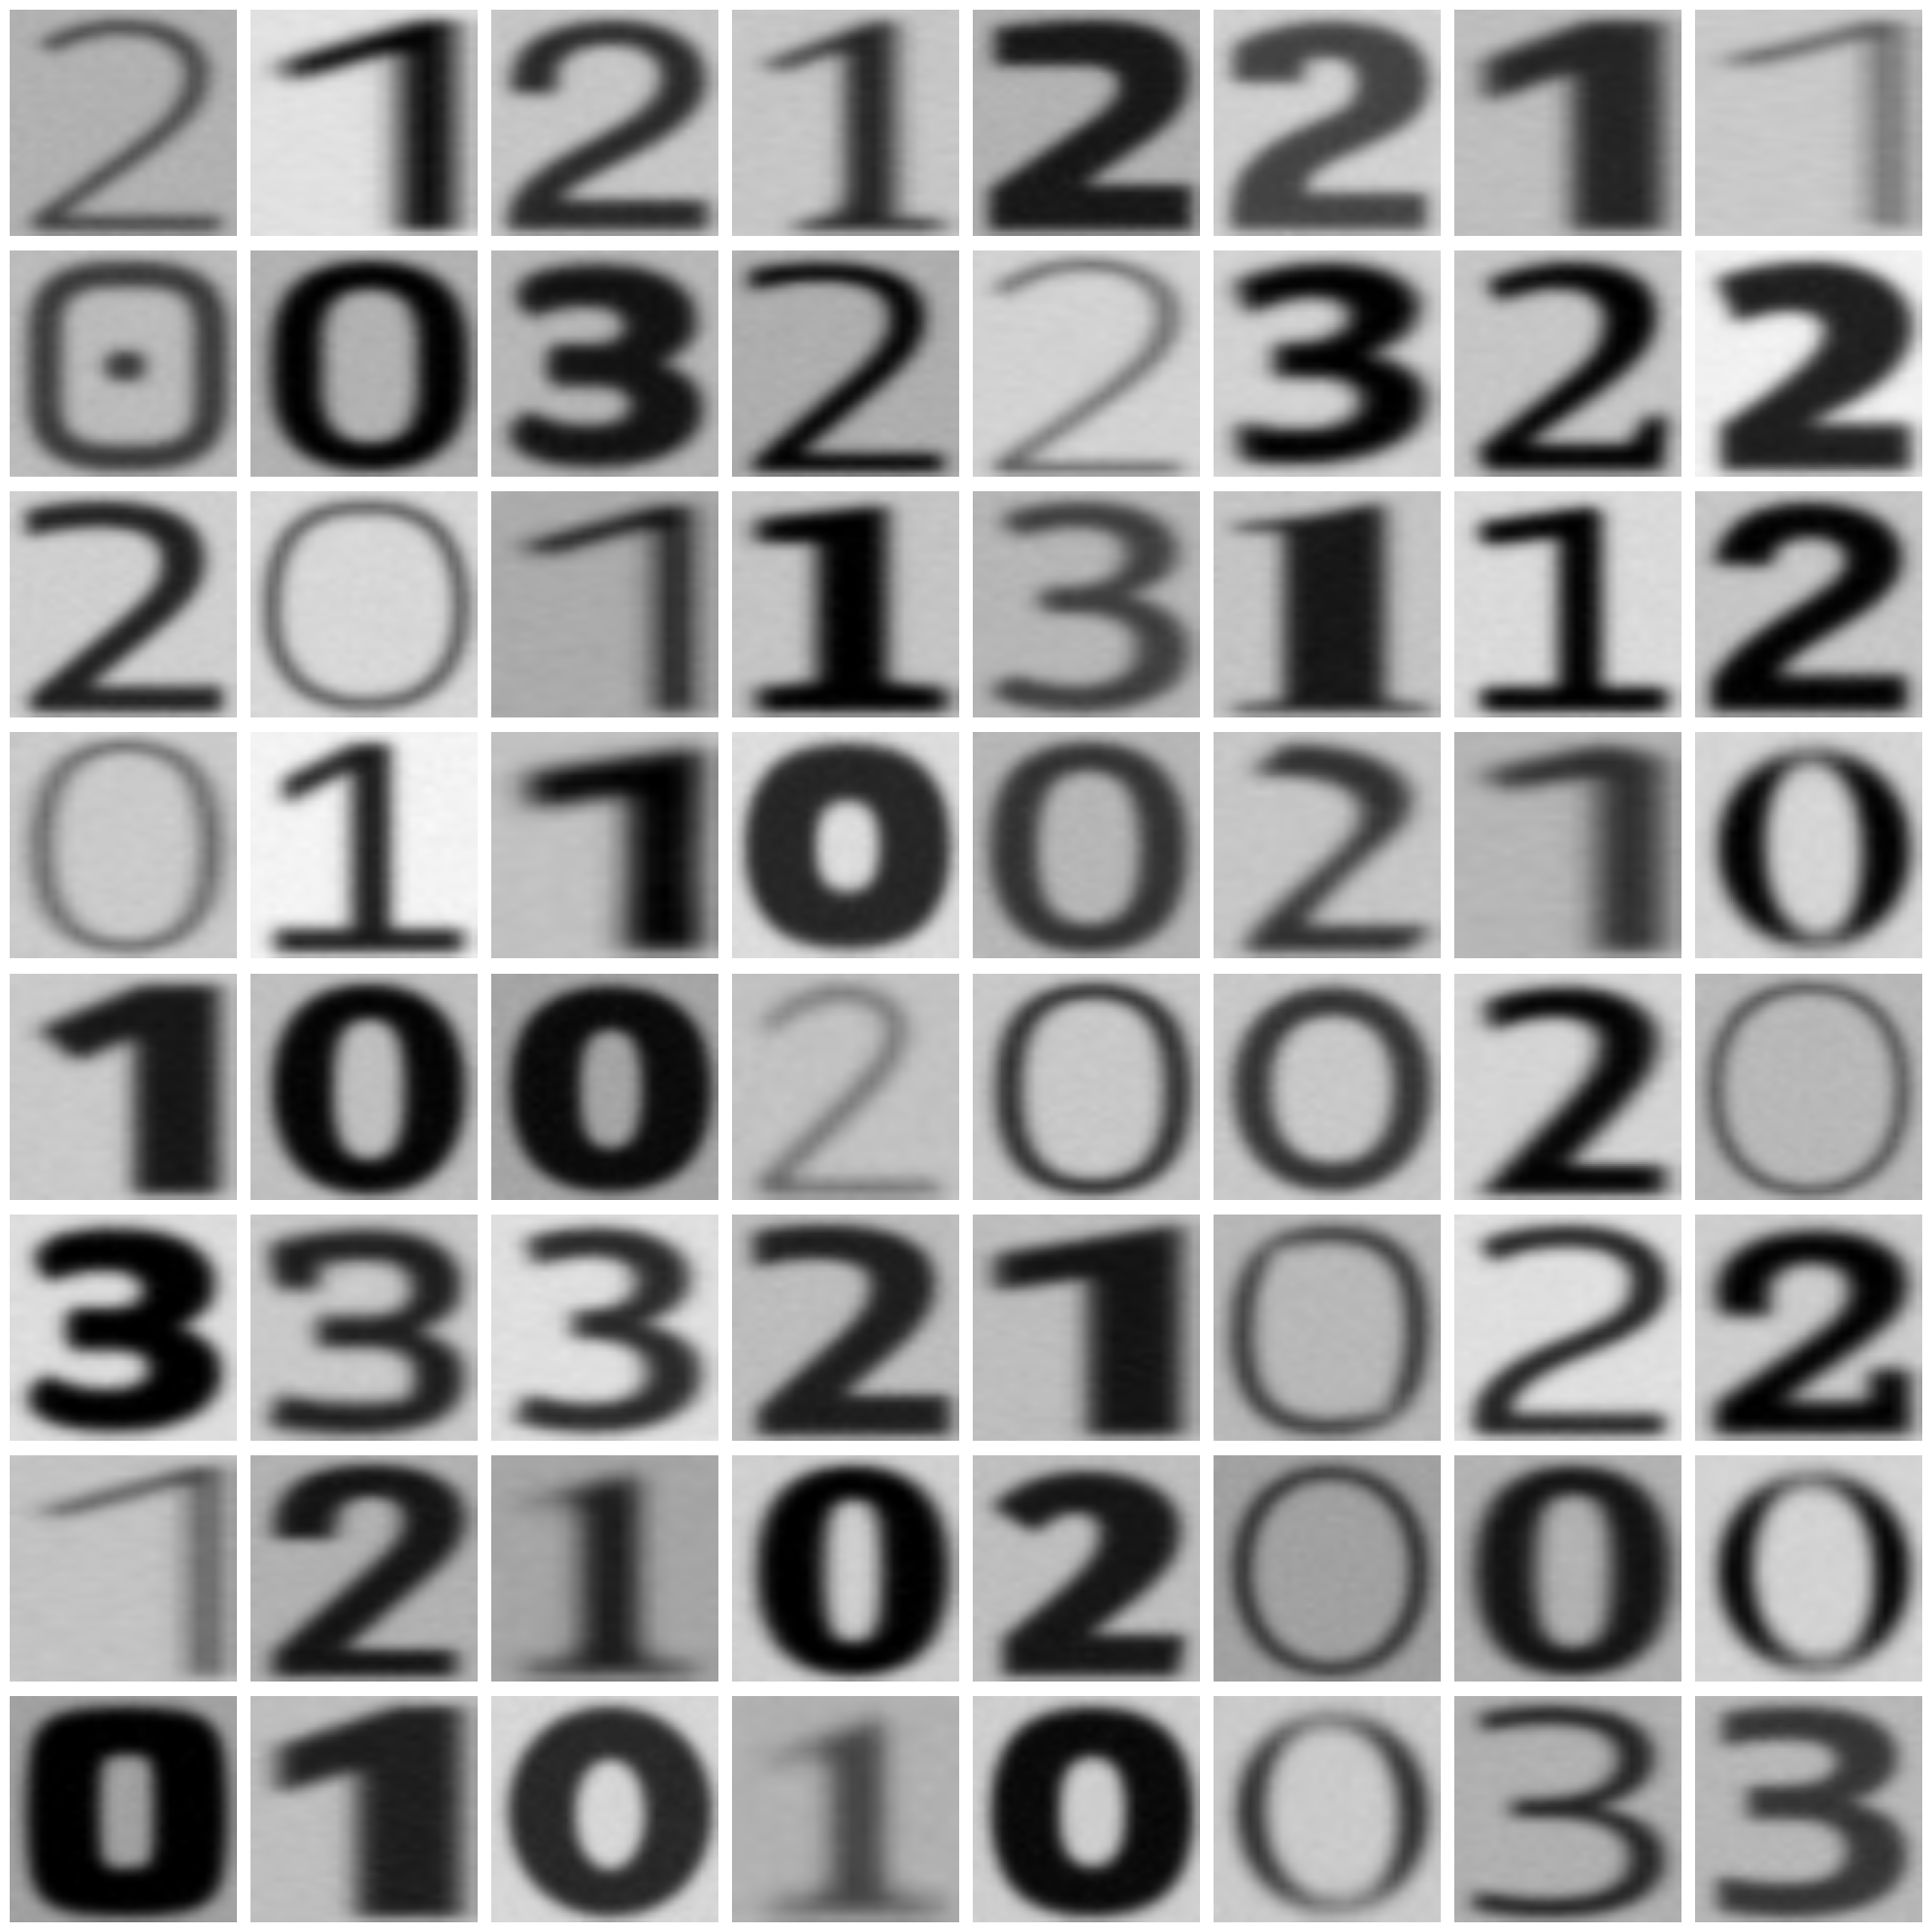

In [36]:
show_images(data=train_ds)

In [37]:
# All the backbones will be accessed through a name.
BACKBONE_NAMES = [
    'ResNet50',
    'ResNet50V2',
    'ResNet152V2',
    'Inception',
    'Xception',
    'MobileNet'
]